In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from numba import jit

In [3]:
N_molecules = 1981 #Number of molecules having atom : atomname
N_timesteps = 200  #Number of time steps for which N_molecules trajectory was stored
xlim = [0,210] #Max Limits on X coord 
ylim = [0,210] #Max Limits on Y coord
zlim = [0,90]  #Max Limits on Z coord

In [4]:
#Use mask and apply it over all arrays
def get_clean_coord(X,Y,Z,timestep):
    i = timestep
    X_clean = np.ma.masked_where(X[:,i]>xlim[1], X[:,i]) 
    Y_clean = np.ma.masked_where(X[:,i]>xlim[1], Y[:,i])
    Z_clean = np.ma.masked_where(X[:,i]>xlim[1], Z[:,i])
    
    X_clean = np.ma.masked_where(X_clean[:]<xlim[0], X_clean[:]) 
    Y_clean = np.ma.masked_where(X_clean[:]<xlim[0], Y_clean[:])
    Z_clean = np.ma.masked_where(X_clean[:]<xlim[0], Z_clean[:])
    
    X_clean = np.ma.masked_where(Y_clean[:]>ylim[1], X_clean[:]) 
    Y_clean = np.ma.masked_where(Y_clean[:]>ylim[1], Y_clean[:]) 
    Z_clean = np.ma.masked_where(Y_clean[:]>ylim[1], Z_clean[:])
    
    X_clean = np.ma.masked_where(Y_clean[:]<ylim[0], X_clean[:]) 
    Y_clean = np.ma.masked_where(Y_clean[:]<ylim[0], Y_clean[:]) 
    Z_clean = np.ma.masked_where(Y_clean[:]<ylim[0], Z_clean[:])
    
    
    X_clean = np.ma.masked_where(Z_clean[:]>zlim[1], X_clean[:]) 
    Y_clean = np.ma.masked_where(Z_clean[:]>zlim[1], Y_clean[:])
    Z_clean = np.ma.masked_where(Z_clean[:]>zlim[1], Z_clean[:])
    
    X_clean = np.ma.masked_where(Z_clean[:]<zlim[0], X_clean[:]) 
    Y_clean = np.ma.masked_where(Z_clean[:]<zlim[0], Y_clean[:])
    Z_clean = np.ma.masked_where(Z_clean[:]<zlim[0], Z_clean[:])
    
    return X_clean, Y_clean, Z_clean
    

In [5]:

# Get coordinates of atom having name : atomname from file named : filename and store in a local txt file

def gen_txt(filename, atomname):
    pdb = open('./PDB/'+filename+'.pdb')
    trimmed_pdb = open('Coord_'+filename+'.txt',"w")
    for line in pdb:
        if line[0] == 'A' and line[13] == atomname:
            trimmed_pdb.write(line[31:45]+' '+line[47:55] +'\n')
    pdb.close()
    trimmed_pdb.close()
    
def get_coordinates(filename):
    trimmed_pdb = open('Coord_'+filename+'.txt')
    x = []
    for line in trimmed_pdb:
        x.append(line)
    
    X = np.zeros((N_molecules,N_timesteps))
    Y = np.zeros((N_molecules,N_timesteps))
    Z = np.zeros((N_molecules,N_timesteps))
    for j in range(0,N_molecules*N_timesteps):
        c = [float(i) for i in x[j].split()]
        i1 = j%N_molecules
        j1 = int(j/N_molecules)
        X[i1][j1] = c[0]
        Y[i1][j1] = c[1]
        Z[i1][j1] = c[2]
        
    return X,Y,Z

def plot_snapshot(X, Y, Z, timestep):
    plt.scatter(X[:,timestep],Z[:,timestep])


In [6]:
@jit
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [7]:
@jit
def get_rho(cell_size,xlim,ylim,zlim,x0,y0,z0,padding,dx,dz):
    
    p = cell_size/2
    q = padding
    
    #Populate Density Matrix for each cell
    rho = np.zeros((int((xlim[1]-xlim[0]+2*q)/dx),int((zlim[1]-zlim[0]+2*q)/dz)))

    for x in range(-q*Nx,(xlim[1]-xlim[0]+q)*Nx):
        for z in range(-q*Nz,(zlim[1]-zlim[0]+q)*Nz):
            y_temp = y0[(x0>x/Nx+xlim[0]-p) & (x0<x/Nx+xlim[0]+p) & (z0>z/Nz+zlim[0]-p) & (z0<z/Nz+zlim[0]+p)]
            if y_temp.size != 0 and y_temp.max() != y_temp.min():
                rho[x+q*Nx][z+q*Nz] = y_temp.shape[0]/(y_temp.max()-y_temp.min())
    return rho 

In [8]:
def plot_rho(rho,padding,xlim,zlim,dx,dz):
    q = padding
    Nx = int(1/dx)
    Nz = int(1/dz)
    z_ax = np.linspace((zlim[0]-q)*Nz, (zlim[1]+q-1)*Nz,  (zlim[1]+2*q-zlim[0])*Nz)
    x_ax = np.linspace((xlim[0]-q)*Nx, (xlim[1]+q-1)*Nx,  (xlim[1]+2*q-xlim[0])*Nx)
    x_ax, z_ax = np.meshgrid(x_ax,z_ax)
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_surface(z_ax, x_ax, rho.T,cmap='viridis')
    ax.set_xlabel('Z')
    ax.set_ylabel('X')
    ax.view_init(-90, 0)
    fig

In [9]:
#Example : Generate txt file of coordinates of oxygen ('O') from pdb file with name 'e=0.5_E=0' 
gen_txt('e=2.5_E=0','O')

In [10]:
X,Y,Z = get_coordinates('e=2.5_E=0')
q = 5 #Padding
dx = 0.1
dz = 0.1
Nx = int(1/dx)
Nz = int(1/dz)

In [15]:
#Get the Diameter List (this is slow!)
D = [] #Dia List
dx = 0.1
dz = 0.1
Nx = int(1/dx)
Nz = int(1/dz)
for t in range(50,150):
    x0,y0,z0 = get_clean_coord(X,Y,Z,t)
    xlim = [int(x0.min()),int(np.ceil(x0.max()))] #New Limits
    ylim = [int(y0.min()),int(np.ceil(y0.max()))] #New Limits
    zlim = [int(z0.min()),int(np.ceil(z0.max()))] #New Limits
    rho = get_rho(6.8,np.asarray(xlim),np.asarray(ylim),np.asarray(zlim),x0,y0,z0,q,dx,dz) #Get rho Cell_Size of 6.8
    r = rho.flatten()
    r = np.median(r)
    d = find_nearest(rho[:,(4+q)*Nz][int(rho.shape[0]/2):],r/2)+int(rho.shape[0]/2) -find_nearest(rho[:,(4+q)*Nz][0:int(rho.shape[0]/2)],r/2)
    D.append(d*dx)

Text(0.5, 0, 'Timestep')

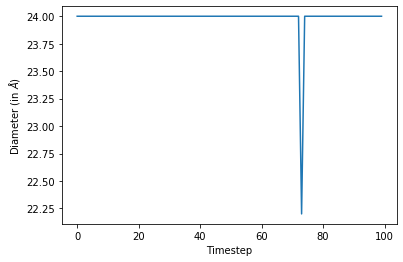

In [16]:
plt.plot(D)
plt.ylabel(r'Diameter (in $\AA$)')
plt.xlabel('Timestep')

In [15]:
x0,y0,z0 = get_clean_coord(X,Y,Z,100)

Text(0.5, 0, 'z-distance from bottom')

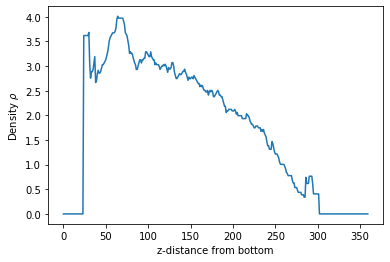

In [37]:
plt.plot(rho[int(rho.shape[0]*0.5),:])
plt.ylabel(r'Density $ \rho $')
plt.xlabel('z-distance from bottom')

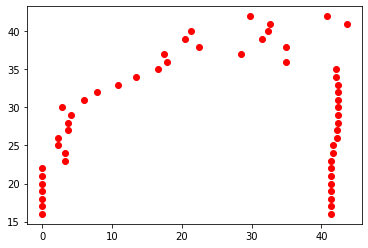

In [33]:
x0,y0,z0 = get_clean_coord(X,Y,Z,100)
xlim = [int(x0.min()),int(np.ceil(x0.max()))]
ylim = [int(y0.min()),int(np.ceil(y0.max()))]
zlim = [int(z0.min()),int(np.ceil(z0.max()))]
rho = get_rho(6.8,xlim,ylim,zlim,x0,y0,z0,5) #Get rho Cell_Size of 6.8
r = rho.flatten()
r = np.median(r)

for z in range(0,27):
    p1 = find_nearest(rho[:,int((z+q)*Nz)],r/2)
    p2 = find_nearest(rho[:,int((z+q)*Nz)][p1+int(rho.shape[0]*0.25):],r/2)+p1+int(rho.shape[0]*0.25)
    if p2 > p1:
        plt.plot(p1/Nx,z+zlim[0],'ro')
        plt.plot(p2/Nz,z+zlim[0],'ro')


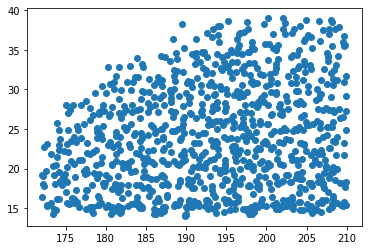

In [17]:
plt.scatter(x0,z0)

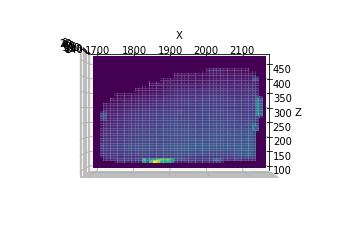

In [36]:
plot_rho(rho,5,xlim,zlim,dx,dz)